### In this part, we train approrpiately surrogates that are going to replace analytical functions which are important for describing the physics of the mean diesel engine system. In fact, these surrogates will be pre-trained NNs with the form of a classic FFNN. The target values $y$ for each pre-trained NN are calculated with labelled data according to empirical formulae. As long as the PINN model we are trying to construct does give random predictions for the state variable dynamics at the beginning of the training process, we will try to approximate the true values of the surrogates giving them noisy data as input. Consequently, we are interested in finding the maximum noise under which our surrogates predict the expected true outputs effectively.


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
import math

# Generated Clean Data

## Data from Simulink

### Dataset generated for Simulink model

In [77]:
# We import the whole dataset from Simulink
df = pd.read_excel(r"C:\Users\dimka\Documents\MyThesis\Initial Work\Diesel Engine - Clean Data.xlsx")
df = df.drop(df.index[1:9]).reset_index(drop=True) # false values generated from stimuling in small time points
df


,Time,BSR,eta_c,eta_tm,lambda,M_e,n_e,n_t,P_c,p_em,...,u_vgt,W_c,W_egr,W_ei,W_eo,W_f,W_t,x_r,u_egract,u_vgtact
0,0.000000,1.951041,0.200000,0.200000,0.009519,-171.342606,1500,49999.289307,261.261029,102371.759481,...,59.47,0.270270,0.003344,0.177690,0.185940,0.00825,0.020975,0.020222,80.000000,30.000000
1,0.021919,0.629172,0.200000,0.642131,0.309118,105.972246,1500,49342.660742,10013.924784,126779.641219,...,59.47,0.258459,0.043630,0.193252,0.201502,0.00825,0.096070,0.023646,80.000000,30.000000
2,0.031917,0.566922,0.332890,0.573281,0.427609,219.038720,1500,48877.589630,8115.513966,133496.117515,...,59.47,0.247234,0.049861,0.200068,0.208318,0.00825,0.109067,0.023678,80.000000,30.000000
3,0.034242,0.556992,0.356781,0.561252,0.453028,243.383424,1500,48793.370513,7949.438717,134851.260190,...,59.47,0.244505,0.051011,0.201531,0.209781,0.00825,0.111606,0.024454,80.000000,30.000000
4,0.036566,0.548066,0.378743,0.550193,0.477677,267.010109,1500,48715.151490,7816.974870,136142.945621,...,59.47,0.241737,0.052076,0.202947,0.211197,0.00825,0.113988,0.024625,80.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.587182,0.684212,0.595861,2.194658,786.711911,1500,63070.987184,15377.647697,170253.330355,...,52.61,0.251724,0.024811,0.275010,0.283260,0.00825,0.255270,0.027381,37.514234,53.723419
2196,59.867654,0.585477,0.684798,0.593906,2.195081,786.292749,1500,63075.022081,15366.473865,170778.771345,...,52.61,0.251345,0.025675,0.275194,0.283444,0.00825,0.254940,0.027432,37.490123,53.167830
2197,59.896336,0.583514,0.685764,0.591644,2.195681,785.818227,1500,63094.511457,15358.993178,171458.793513,...,52.61,0.250803,0.026647,0.275543,0.283793,0.00825,0.255338,0.027491,37.458454,52.774001
2198,59.936597,0.582434,0.686747,0.590391,2.196217,785.551042,1500,63146.575687,15379.378985,172004.701219,...,52.61,0.250469,0.027200,0.276007,0.284257,0.00825,0.256158,0.027565,37.442660,52.635209


### Constants

In [78]:
  #-------------   Table 7 --------------#
Ra = 287.0
Tim = 300.6186
Vim = 0.0220
Re = 286.0
Vem = 0.0200
Vd = 0.0127
ncyl = 6.0
gamma_a = 1.3964
cpa = 1011.0
cva = 724.0
rc = 17.0
xcv = 2.3371e-14
qHV = 42900000
dpipe = 0.1
lpipe = 1.0
npipe = 2.0
cpe = 1332.0
tegr1 = 0.05
tegr2 = 0.13
tdegr = 0.065
Kegr = 1.8
Pi_egropt = 0.6500
Jt = 2.0e-4
tvgt = 0.025
tdvgt = 0.04
cpe = 1332.0
gamma_e = 1.2734

Rt = 0.04
Rc = 0.0400
#----------   Table 9  -------------#
cvol1 = -2.0817e-4
cvol2 = -0.0034
cvol3 = 1.1497
cwpsi1 = 1.0882e-8
cwpsi2 = -1.7320e-4
cwpsi3 = 1.0286
pcopt = 1.0455
Wcopt = 0.2753
a1 = 3.0919
a2 = 2.1479
a3 = -2.4823
eta_cmax = 0.7364
cp = 0.2708
cegr1 = -1.1104e-4
cegr2 = 0.0178
cegr3 = 0.0
cwphi1 = -1.4298e-8
cwphi2 = -0.0015

cwphi3 = 29.6462
cm1 = 1.3563
cm2 = 2.7692e3
cm3 = 0.0100
BSRopt = 0.9755
eta_tm_max = 0.8180
cpsi2 = 0.0
cphi2 = 0.0
cvgt1 = 126.8719
cvgt2 = 117.1447
cf1 = 1.9480
cf2 = -0.7763
Kt = 2.8902

h_tm_max = 0.8180
#---------------True values of unknown parameters-----------------#
Aegrmax_true = 4.0e-4
eta_sc_true = 1.1015
htot_true = 96.2755
Avgtmax_true = 8.4558e-4
#---------------#
pi = np.pi
pamb = 1.0111e5
Tamb = 298.4636
#----Guesses----#
cpsi1 , cphi1 = 1.0, 1.0

## Numerically generated Data

### The stimulink model does not provide data for turbo speed $ω_{t}$, EGR1 valve position $\tilde{u}_{egr1}$ , EGR2 valve position $\tilde{u}_{egr2}$ and VGT actuator position $\tilde{u}_{vgt}$. These variables---or functions of those--- have to be used as input for the training of our surrogates. Data for these variables will be generated with the numerical solution of the ODE that describes the physics of each variable. We have to numerically generate data for training, validation and testing datasets.

#### Initial conditions

In [79]:
omegat0 = 5.236e3
u_egr10 = 18.2518
u_egr20 = 18.1813
u_vgt0 = 59.47

In [80]:
# we are going to solve the ODEs in the whole time domain (0,60s)
time = df['Time']
time = np.array(time)
time

array([0.00000000e+00, 2.19187518e-02, 3.19167751e-02, ...,
       5.98963357e+01, 5.99365975e+01, 6.00000000e+01], shape=(2200,))

#### Data needed for solving the ODEs

In [81]:
# Data for u_egr, u_vgt
uvgt_data = df['u_vgtact']
uegr_data = df['u_egract']

# Data for omegat
Pc_data = df['P_c']
eta_tm_data = df['eta_tm']
Wt_data = df['W_t']
Tem_data = df['T_em']
pem_data = df['p_em']



In [82]:
### We solve with numerical integration the ODes for u_egr1, u_egr2, u_vgt, omegat

##----- Defining the ODEs ------#

# ODE for u_vgt
uvgt_interp = interp1d(time, uvgt_data, kind='linear', fill_value="extrapolate", bounds_error=False)

def ODE_u_vgt(t,y):
    u_vgt = y
    uvgt_t = uvgt_interp(t)

    du_vgt_t = (1/tvgt) * (uvgt_t - u_vgt)

    return du_vgt_t


# ODE system for u_egr1, u_egr2
uegr_interp = interp1d(time, uegr_data, kind='linear', fill_value="extrapolate") # type: ignore

def ODE_system_u_egr1_u_egr2(t,y):
    u_egr1, u_egr2 = y
    uegr_interp_t = uegr_interp(t)

    du_egr1_t = (1/tegr1) * (uegr_interp_t - u_egr1)
    du_egr2_t = (1/tegr2) * (uegr_interp_t - u_egr2)

    return du_egr1_t, du_egr2_t


# ODE for omegat
Pc_interp = interp1d(time, Pc_data, kind='linear', fill_value="extrapolate") # pyright: ignore[reportArgumentType]

Pi_t = pamb/pem_data
Pt_eta_m = eta_tm_data * Wt_data * cpe * Tem_data * (1 - (Pi_t)**(1-1/gamma_e))
Pt_eta_m_interp = interp1d(time, Pt_eta_m, kind='linear', fill_value="extrapolate", bounds_error=False)

def ODE_omegat(t,y):
    omegat = y
    Pc_t = Pc_interp(t)
    Pt_eta_m_t = Pt_eta_m_interp(t)

    domegat_t = (Pt_eta_m_t - Pc_t)/(Jt * omegat)

    return domegat_t


In [83]:
len(Pt_eta_m)

2200

In [84]:
len(time)

2200

In [85]:
# Generating Data for the variables

def gen_data_u_vgt():
    t = time
    sol = integrate.solve_ivp(ODE_u_vgt, (0,60), [u_vgt0], method='RK45', t_eval=t)
    u_vgt_data = sol.y[0]

    return u_vgt_data

def gen_data_u_egr1_u_egr2():
    t = time
    u_egr120 = [u_egr10, u_egr20]
    sol = integrate.solve_ivp(ODE_system_u_egr1_u_egr2, (0,60), u_egr120, method='RK45', t_eval=t)
    u_egr1_data = sol.y[0]
    u_egr2_data = sol.y[1]

    return u_egr1_data, u_egr2_data


def gen_data_omegat():
    t = time
    sol = integrate.solve_ivp(ODE_omegat, (0,60), [omegat0], method='RK45', t_eval=t)
    omegat_data = sol.y[0]

    return omegat_data

In [86]:
# Data for u_vgt
u_vgt_data = gen_data_u_vgt()

# Data for u_egr1, u_egr2
u_egr1_data, u_egr2_data = gen_data_u_egr1_u_egr2()

# Data for omegat
omegat_data = gen_data_omegat()



In [87]:
# Data for a variable u_egr
u_egr_data = Kegr * u_egr1_data - (Kegr - 1) * u_egr2_data

## Whole Dataset

In [88]:
# We insert the numerically generated data to the initial Simulink dataset
df['u_egr1'] = u_egr1_data
df['u_egr2'] = u_egr2_data
df['u_vgt'] = u_vgt_data
df['omegat'] = omegat_data
df['u_egr'] = u_egr_data


In [89]:
# Whole Dataset : Simulink Data + Numerically Generated Data
df_generated = df
df_generated

,Time,BSR,eta_c,eta_tm,lambda,M_e,n_e,n_t,P_c,p_em,...,W_ei,W_eo,W_f,W_t,x_r,u_egract,u_vgtact,u_egr1,u_egr2,omegat
0,0.000000,1.951041,0.200000,0.200000,0.009519,-171.342606,1500,49999.289307,261.261029,102371.759481,...,0.177690,0.185940,0.00825,0.020975,0.020222,80.000000,30.000000,18.251800,18.181300,5236.000000
1,0.021919,0.629172,0.200000,0.642131,0.309118,105.972246,1500,49342.660742,10013.924784,126779.641219,...,0.193252,0.201502,0.00825,0.096070,0.023646,80.000000,30.000000,40.168104,27.772979,5173.721536
2,0.031917,0.566922,0.332890,0.573281,0.427609,219.038720,1500,48877.589630,8115.513966,133496.117515,...,0.200068,0.208318,0.00825,0.109067,0.023678,80.000000,30.000000,47.398776,31.639157,5128.478697
3,0.034242,0.556992,0.356781,0.561252,0.453028,243.383424,1500,48793.370513,7949.438717,134851.260190,...,0.201531,0.209781,0.00825,0.111606,0.024454,80.000000,30.000000,48.882490,32.496330,5118.098000
4,0.036566,0.548066,0.378743,0.550193,0.477677,267.010109,1500,48715.151490,7816.974870,136142.945621,...,0.202947,0.211197,0.00825,0.113988,0.024625,80.000000,30.000000,50.298104,33.338305,5107.971076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.587182,0.684212,0.595861,2.194658,786.711911,1500,63070.987184,15377.647697,170253.330355,...,0.275010,0.283260,0.00825,0.255270,0.027381,37.514234,53.723419,37.550593,37.567470,6964.706525
2196,59.867654,0.585477,0.684798,0.593906,2.195081,786.292749,1500,63075.022081,15366.473865,170778.771345,...,0.275194,0.283444,0.00825,0.254940,0.027432,37.490123,53.167830,37.539053,37.559360,6965.884225
2197,59.896336,0.583514,0.685764,0.591644,2.195681,785.818227,1500,63094.511457,15358.993178,171458.793513,...,0.275543,0.283793,0.00825,0.255338,0.027491,37.458454,52.774001,37.516281,37.542298,6968.322029
2198,59.936597,0.582434,0.686747,0.590391,2.196217,785.551042,1500,63146.575687,15379.378985,172004.701219,...,0.276007,0.284257,0.00825,0.256158,0.027565,37.442660,52.635209,37.482090,37.517548,6972.757291


# Clean Data for Empirical Formulae

## Variables used for calculations of empirical formulae

In [90]:
# Data directly extracted from our generated data frame
Wei_data = df_generated['W_ei']
Wegr_data = df_generated['W_egr']
Wc_data = df_generated['W_c']
Wt_data = df_generated['W_t']
Tem_data = df_generated['T_em']
Tc_data = df_generated['T_c']
pim_data = df_generated['p_im']
pem_data = df_generated['p_em']
ne_data = df_generated['n_e']
omegat_data = df_generated['omegat']

In [91]:
##-----Functions for empirical formulae------##

# Pi_egr
def Pi_egr(pim: np.ndarray, pem: np.ndarray):
    pegr_values = []
    for i in range(len(pim)):
        ratio = pim[i]/pem[i]
        if ratio < Pi_egropt:
            pegr_values.append(Pi_egropt)
        elif ratio > 1:
            pegr_values.append(1)
        else:
            pegr_values.append(ratio)
    return np.array(pegr_values)

pegr_data = Pi_egr(pim_data, pem_data)
Psi_egr_data = (1-((1-pegr_data)/(1-Pi_egropt) -1)**2)

# Pt_eta_m
domegat_t = np.gradient(omegat_data, time)
Pt_eta_m = Pc_data + Jt * omegat_data * domegat_t

# Pi_t
Pi_t = pamb/pem_data

# Pi_c 
Pi_c = pim_data/pamb


## Calculating empirical formulae

In [92]:
# eta_vol
eta_vol_emp = (120 * Wei_data * Ra *Tim)/(pim_data * ne_data * Vd)

# fegr
fegr_emp = Wegr_data * np.sqrt(Tem_data * Re)/(Aegrmax_true * pim_data * Psi_egr_data)

# F_vgt_Pi_t
F_vgt_Pi_t_emp = Wt_data * np.sqrt(Tem_data * Re)/(Avgtmax_true * pem_data)

# eta_tm 
eta_tm_emp = Pt_eta_m/(Wt_data * cpe * Tem_data * (1 - Pi_t**(1 - 1/gamma_e)))

# eta_c
eta_c_emp = (Tamb * (Pi_c**(1 - 1/gamma_a) -1))/(Tc_data - Tamb)

# Phi_c
Phi_c_emp = Ra * Tamb * Wc_data/(pamb * pi * omegat_data * (Rc**3))

In [93]:
# Empirical Formulae
df['eta_vol_emp'] = eta_vol_emp
df['fegr_emp'] = fegr_emp
df['F_vgt_Pi_t_emp'] = F_vgt_Pi_t_emp
df['eta_tm_emp'] = eta_tm_emp
df['eta_c_emp'] = eta_c_emp
df['Phi_c_emp'] = Phi_c_emp

df.loc[0, 'eta_tm_emp'] = df.loc[1, 'eta_tm_emp']
df.loc[0, 'eta_c_emp'] = df.loc[1, 'eta_c_emp']

df['domegat_dt'] = domegat_t


print(df.columns.tolist())


['Time', 'BSR', 'eta_c', 'eta_tm', 'lambda', 'M_e', 'n_e', 'n_t', 'P_c', 'p_em', 'p_im', 'P_tm', 'T_1', 'T_c', 'T_e', 'T_em', 'u_delta', 'u_egr', 'u_vgt', 'W_c', 'W_egr', 'W_ei', 'W_eo', 'W_f', 'W_t', 'x_r', 'u_egract', 'u_vgtact', 'u_egr1', 'u_egr2', 'omegat', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'domegat_dt']


In [94]:
# Creating a DataFrame for empirical formulae
df_empirical = df[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]
df_empirical

,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,n_e,p_em,p_im,omegat,u_vgt,u_egr,W_ei,W_egr,T_em,W_t,W_c,T_c,domegat_dt
0,0.000000,0.952944,0.719035,0.119919,1.133810,0.200027,0.217494,1500,102371.759481,101339.735203,5236.000000,59.470000,18.308200,0.177690,0.003344,856.396676,0.020975,0.270270,299.419771,-2841.332587
1,0.021919,0.949986,0.816219,0.442985,1.133810,0.200027,0.210493,1500,126779.641219,110558.295191,5173.721536,42.271633,50.084203,0.193252,0.043630,854.370456,0.096070,0.258459,336.786809,-3997.708743
2,0.031917,0.948725,0.829078,0.475086,0.495480,0.332920,0.203127,1500,133496.117515,114609.765503,5128.478697,38.177619,60.006470,0.200068,0.049861,845.345229,0.109067,0.247234,330.931762,-4476.496600
3,0.034242,0.948457,0.831178,0.480599,0.457124,0.356811,0.201293,1500,134851.260190,115480.623215,5118.098000,37.440175,61.991419,0.201531,0.051011,843.031519,0.111606,0.244505,330.622310,-4410.597217
4,0.036566,0.948199,0.833060,0.485602,0.435733,0.378773,0.199408,1500,136142.945621,116323.406454,5107.971076,36.813493,63.865944,0.202947,0.052076,840.962862,0.113988,0.241737,330.448542,-4281.963211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.935973,0.544557,0.803468,0.598633,0.684221,0.152290,1500,170253.330355,159686.621004,6964.706525,54.880088,37.537091,0.275010,0.024811,717.912210,0.255270,0.251724,358.888226,64.148320
2196,59.867654,0.935944,0.545611,0.800108,0.596025,0.684807,0.152035,1500,170778.771345,159798.613166,6965.884225,54.198470,37.522807,0.275194,0.025675,718.179396,0.254940,0.251345,358.935341,75.288102
2197,59.896336,0.935888,0.546737,0.798258,0.591538,0.685773,0.151654,1500,171458.793513,160010.580351,6968.322029,53.282042,37.495468,0.275543,0.026647,718.321398,0.255338,0.250803,359.036642,95.463877
2198,59.936597,0.935815,0.547352,0.798157,0.588911,0.686756,0.151356,1500,172004.701219,160292.944131,6972.757291,52.784553,37.453723,0.276007,0.027200,718.099692,0.256158,0.250469,359.197846,126.580060


## Analytical functions for empirical formulae

In [95]:
# eta_vol analytical
eta_vol_analytical = cvol1 * np.sqrt(pim_data) + cvol2 * np.sqrt(ne_data) + cvol3


# fegr analytical
def fegr(u_egr):
    fegr_values = []
    for u_egr_i in u_egr:
        if (u_egr_i <= ( -cegr2/(2 * cegr1))):
            fegr_values.append((cegr1 * (u_egr_i**2) + cegr2 * u_egr_i + cegr3))
        else :
           fegr_values.append(cegr3 - (cegr2**2)/(4 * cegr1))
    return np.array(fegr_values)

fegr_analytical = fegr(u_egr_data)


# F_vgt_Pi_t_analytical
def fvgt_Pit(u_vgt : np.ndarray, pem: np.ndarray):
  f_vgt_values = []
  f_pit_values = []

  for i in range(len(u_vgt)):
      f_vgt_values.append(cf2 + cf1 * np.sqrt(np.maximum(0, 1 - ((u_vgt[i] - cvgt2)/cvgt1)**2)))
      f_pit_values.append(np.sqrt(1 - (pamb/pem[i])**Kt))

  fvgt_Pit_values = np.array(f_vgt_values) * np.array(f_pit_values)
  return fvgt_Pit_values

fvgt_Pit_analytical = fvgt_Pit(u_vgt_data, pem_data)


# eta_tm_analytical
def eta_tm(BSR :np.ndarray, omegat: np.ndarray):
    cm = cm1 * ((np.maximum(0, omegat - cm2))**cm3)
    h_tm_values = h_tm_max - cm * ((BSR - BSRopt)**2)
    return h_tm_values

BSR = (Rt * omegat_data)/np.sqrt(2 * cpe * Tem_data * (1 - ((pamb/pem_data)**(1 - 1/gamma_e))))

eta_tm_analytical = eta_tm(BSR, omegat_data)

## eta_c_analytical
pi_c = (Pi_c - 1) ** cp

# X matric
X = np.vstack([
    Wc_data - Wcopt,
    pi_c - pcopt
])  # shape: (2, N)

# Q_c matrix
Q_c = np.array([
    [a1, a3],
    [a3, a2]
])

# Quadratic form for each time step
QX = Q_c @ X  # (2, N)
quad_form = np.einsum('ij,ij->j', X, QX)  # (N,)

eta_c_analytical = eta_cmax - quad_form

# Phi_c 
def cpsi1_func(omegat: np.ndarray):
    return cwpsi1 * omegat**2 + cwpsi2 * omegat + cwpsi3

def cphi1_func(omegat: np.ndarray):
    return cwphi1 * omegat**2 + cwphi2 * omegat + cwphi3

cpsi1_vals = cpsi1_func(omegat_data)
cphi1_vals = cphi1_func(omegat_data)

Psi_c = 2 * cpa * Tamb * (((pim_data / pamb) ** (1 - 1 / gamma_a)) - 1) / (Rc ** 2 * omegat_data ** 2)

Phi_c_analytical = np.sqrt(
    np.maximum(0, (1 - cpsi1_vals * (Psi_c - cpsi2) ** 2) / cphi1_vals)
) + cphi2


In [96]:
print(omegat_data)

0       5236.000000
1       5173.721536
2       5128.478697
3       5118.098000
4       5107.971076
           ...     
2195    6964.706525
2196    6965.884225
2197    6968.322029
2198    6972.757291
2199    6982.422156
Name: omegat, Length: 2200, dtype: float64


In [97]:
df_analytical = pd.DataFrame(time, columns=['Time'])
df_analytical['eta_vol'] = eta_vol_analytical
df_analytical['fegr'] = fegr_analytical
df_analytical['F_vgt_Pi_t'] = fvgt_Pit_analytical
df_analytical['eta_tm'] = eta_tm_analytical
df_analytical['eta_c'] = eta_c_analytical
df_analytical['Phi_c'] = Phi_c_analytical

df_analytical

,Time,eta_vol,fegr,F_vgt_Pi_t,eta_tm,eta_c,Phi_c
0,0.000000,0.951750,0.288666,0.179907,-3.487501,-0.805706,0.216164
1,0.021919,0.948801,0.612963,0.551688,0.642964,0.199911,0.209580
2,0.031917,0.947545,0.668285,0.556044,0.574634,0.332816,0.202514
3,0.034242,0.947277,0.676728,0.555677,0.562410,0.356711,0.200613
4,0.036566,0.947020,0.683897,0.555522,0.551102,0.378676,0.198635
...,...,...,...,...,...,...,...
2195,59.850723,0.934832,0.511701,0.812448,0.630830,0.684226,0.179121
2196,59.867654,0.934803,0.511566,0.808229,0.629005,0.684811,0.178975
2197,59.896336,0.934748,0.511307,0.802346,0.626839,0.685778,0.178711
2198,59.936597,0.934674,0.510911,0.799402,0.625502,0.686761,0.178414


# Clean Data for PINNs 

In [98]:
print(df.columns.tolist())

['Time', 'BSR', 'eta_c', 'eta_tm', 'lambda', 'M_e', 'n_e', 'n_t', 'P_c', 'p_em', 'p_im', 'P_tm', 'T_1', 'T_c', 'T_e', 'T_em', 'u_delta', 'u_egr', 'u_vgt', 'W_c', 'W_egr', 'W_ei', 'W_eo', 'W_f', 'W_t', 'x_r', 'u_egract', 'u_vgtact', 'u_egr1', 'u_egr2', 'omegat', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp', 'eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'domegat_dt']


In [99]:
df_pinns = df[['Time', 'p_im', 'p_em', 'omegat', 'u_egr1', 'u_egr2', 'u_vgt', 'T_1', 'x_r', 'W_egr','u_egract', 'u_vgtact']]
df_pinns

,Time,p_im,p_em,omegat,u_egr1,u_egr2,u_vgt,T_1,x_r,W_egr,u_egract,u_vgtact
0,0.000000,101339.735203,102371.759481,5236.000000,18.251800,18.181300,59.470000,314.948446,0.020222,0.003344,80.000000,30.000000
1,0.021919,110558.295191,126779.641219,5173.721536,40.168104,27.772979,42.271633,317.040796,0.023646,0.043630,80.000000,30.000000
2,0.031917,114609.765503,133496.117515,5128.478697,47.398776,31.639157,38.177619,317.057631,0.023678,0.049861,80.000000,30.000000
3,0.034242,115480.623215,134851.260190,5118.098000,48.882490,32.496330,37.440175,317.196772,0.024454,0.051011,80.000000,30.000000
4,0.036566,116323.406454,136142.945621,5107.971076,50.298104,33.338305,36.813493,317.216516,0.024625,0.052076,80.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,159686.621004,170253.330355,6964.706525,37.550593,37.567470,54.880088,314.034593,0.027381,0.024811,37.514234,53.723419
2196,59.867654,159798.613166,170778.771345,6965.884225,37.539053,37.559360,54.198470,314.066629,0.027432,0.025675,37.490123,53.167830
2197,59.896336,160010.580351,171458.793513,6968.322029,37.516281,37.542298,53.282042,314.102795,0.027491,0.026647,37.458454,52.774001
2198,59.936597,160292.944131,172004.701219,6972.757291,37.482090,37.517548,52.784553,314.140840,0.027565,0.027200,37.442660,52.635209


# Applying Noise to Data

## Noisy Generated Data

In [119]:
# Function to add noise to the data
def add_noise(data, noise_std, signal_range):
    noise_std_data = noise_std * signal_range
    noisy_data = data + np.random.normal(0, noise_std_data, data.shape)
    return noisy_data

In [120]:
df_columns = df.columns.tolist()[1:]

df_noisy_data_1 = pd.DataFrame(time, columns=['Time'])
df_noisy_data_2 = pd.DataFrame(time, columns=['Time'])
df_noisy_data_3 = pd.DataFrame(time, columns=['Time'])
df_noisy_data_4 = pd.DataFrame(time, columns=['Time'])
df_noisy_data_5 = pd.DataFrame(time, columns=['Time'])
df_noisy_data_10 = pd.DataFrame(time, columns=['Time'])

 
for col in df_columns:
    col_data = df[col]
    signal_range = col_data.max() - col_data.min()

    if signal_range == 0:
        print(f"Constant signal detected: '{col}'")

        # Use first value as reference for constant signal
        base_value = col_data.iloc[0]

        # 1% noise
        noise_std = 0.01
        noise_std_dev = base_value * noise_std
        df_noisy_data_1[col] = base_value + np.random.normal(0, noise_std_dev, size=len(col_data))

        # 2% noise
        noise_std = 0.02
        noise_std_dev = base_value * noise_std
        df_noisy_data_2[col] = base_value + np.random.normal(0, noise_std_dev, size=len(col_data))

        # 3% noise
        noise_std = 0.03
        noise_std_dev = base_value * noise_std
        df_noisy_data_3[col] = base_value + np.random.normal(0, noise_std_dev, size=len(col_data))

        # 4% noise
        noise_std = 0.04
        noise_std_dev = base_value * noise_std
        df_noisy_data_4[col] = base_value + np.random.normal(0, noise_std_dev, size=len(col_data))
        
        # 5% noise
        noise_std = 0.05
        noise_std_dev = base_value * noise_std
        df_noisy_data_5[col] = base_value + np.random.normal(0, noise_std_dev, size=len(col_data))
        
        # 10% noise
        noise_std = 0.1
        noise_std_dev = base_value * noise_std
        df_noisy_data_10[col] = base_value + np.random.normal(0, noise_std_dev, size=len(col_data))

    else:
        # Use existing add_noise function for variable signals
        df_noisy_data_1[col] = add_noise(col_data, 0.01, signal_range)
        df_noisy_data_2[col] = add_noise(col_data, 0.02, signal_range)
        df_noisy_data_3[col] = add_noise(col_data, 0.03, signal_range)
        df_noisy_data_4[col] = add_noise(col_data, 0.04, signal_range)
        df_noisy_data_5[col] = add_noise(col_data, 0.05, signal_range)
        df_noisy_data_10[col] = add_noise(col_data, 0.1, signal_range)


Constant signal detected: 'n_e'
Constant signal detected: 'u_delta'
Constant signal detected: 'W_f'


## Noisy Data for Surrogates' Training

In [121]:
df_empirical_noisy_1 = df_noisy_data_1[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]
df_empirical_noisy_2 = df_noisy_data_2[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]
df_empirical_noisy_3 = df_noisy_data_3[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]
df_empirical_noisy_4 = df_noisy_data_4[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]
df_empirical_noisy_5 = df_noisy_data_5[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]
df_empirical_noisy_10 = df_noisy_data_10[['Time', 'eta_vol_emp', 'fegr_emp', 'F_vgt_Pi_t_emp','eta_tm_emp', 'eta_c_emp', 'Phi_c_emp', 'n_e', 'p_em', 'p_im', 'omegat', 'u_vgt', 'u_egr', 'W_ei', 'W_egr', 'T_em', 'W_t', 'W_c', 'T_c', 'domegat_dt']]

## Noisy Data for PINNs

In [122]:
df_pinns_noisy_1 = df_noisy_data_1[['Time', 'p_im', 'p_em', 'omegat', 'u_egr1', 'u_egr2', 'u_vgt', 'T_1', 'x_r', 'W_egr','u_egract', 'u_vgtact']]
df_pinns_noisy_2 = df_noisy_data_2[['Time', 'p_im', 'p_em', 'omegat', 'u_egr1', 'u_egr2', 'u_vgt', 'T_1', 'x_r', 'W_egr','u_egract', 'u_vgtact']]
df_pinns_noisy_3 = df_noisy_data_3[['Time', 'p_im', 'p_em', 'omegat', 'u_egr1', 'u_egr2', 'u_vgt', 'T_1', 'x_r', 'W_egr','u_egract', 'u_vgtact']]
df_pinns_noisy_4 = df_noisy_data_4[['Time', 'p_im', 'p_em', 'omegat', 'u_egr1', 'u_egr2', 'u_vgt', 'T_1', 'x_r', 'W_egr','u_egract', 'u_vgtact']]

# Plots

## Clean Data

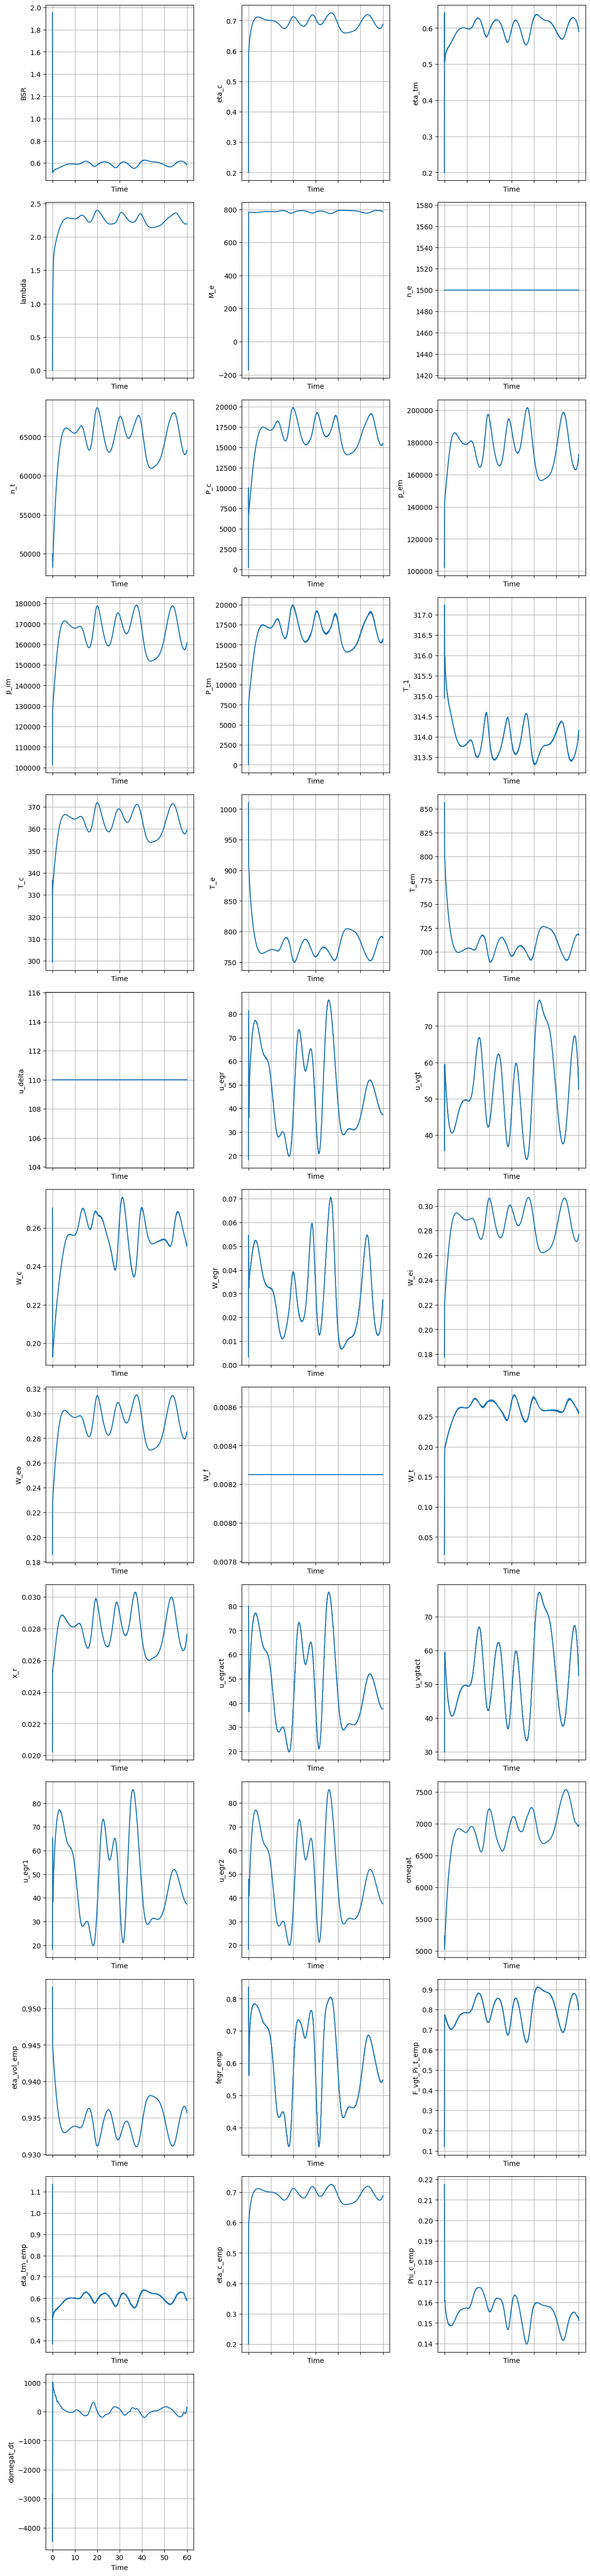

In [104]:
# Extracting time and data columns
time = df.iloc[:, 0]
data_columns = df.columns[1:]

# Setting up subplot grid dimensions
n = len(data_columns)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(n / cols)

# Creating figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axes = axes.flatten()  # Flatten to 1D for easy indexing

# We plot each column in its subplot
for i, col in enumerate(data_columns):
    axes[i].plot(time, df[col])
    axes[i].set_xlabel(df.columns[0])
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# Hiding any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Noisy Data

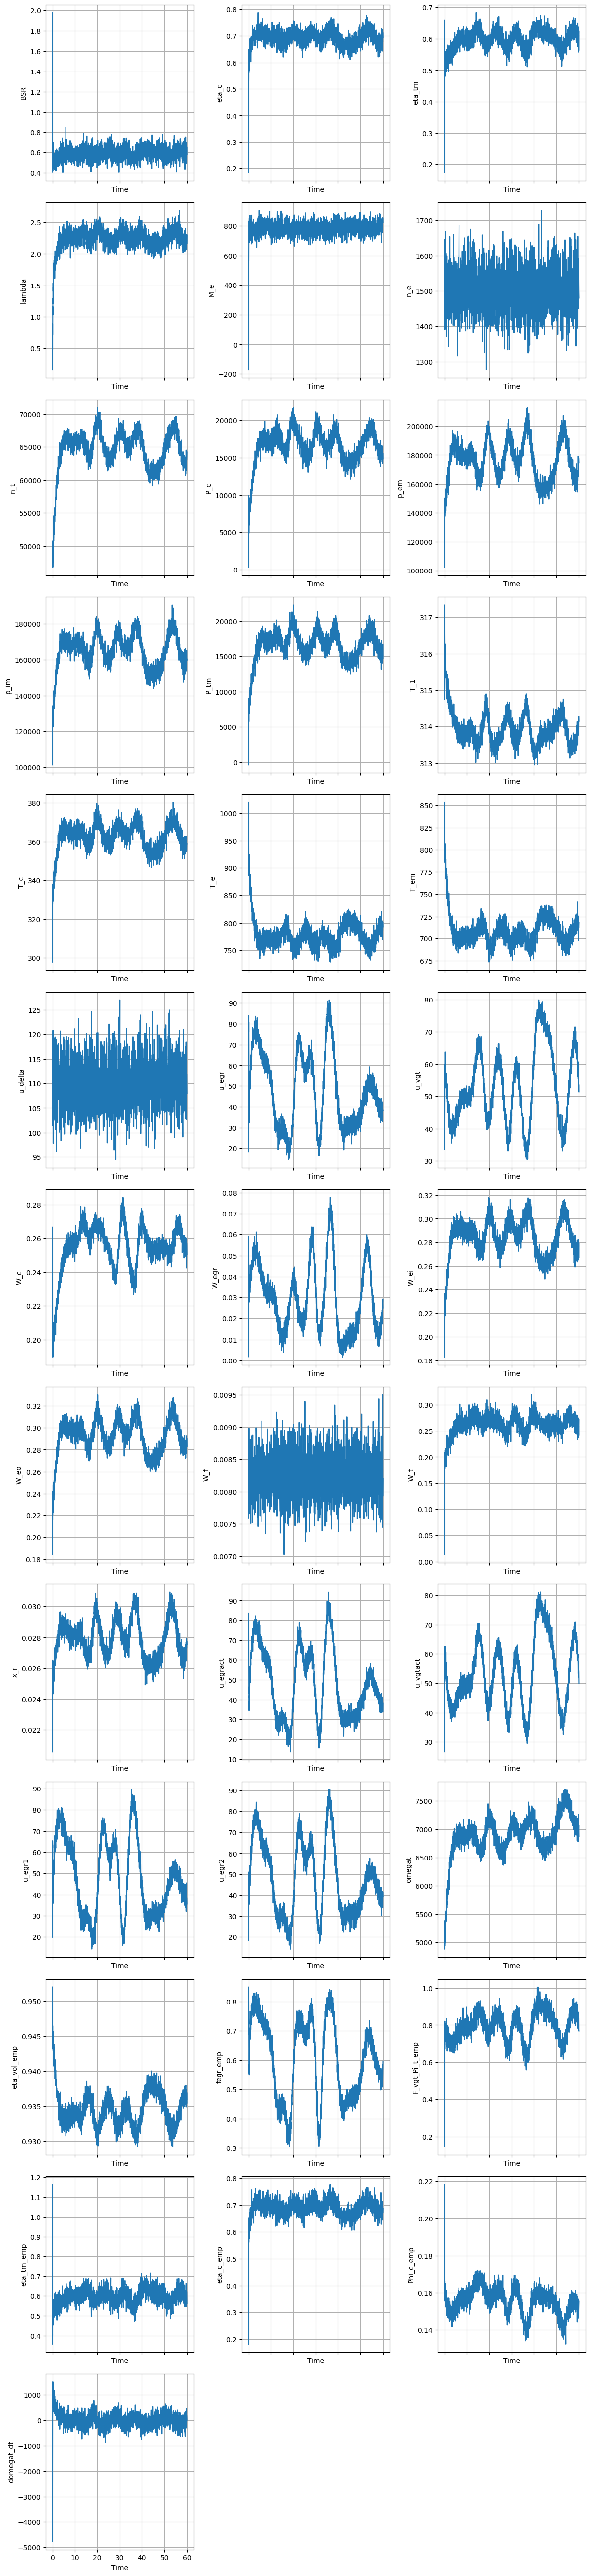

In [105]:
# Extracting time and data columns
time = df_noisy_data_4.iloc[:, 0]
data_columns = df.columns[1:]

# Setting up subplot grid dimensions
n = len(data_columns)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(n / cols)

# Creating figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axes = axes.flatten()  # Flatten to 1D for easy indexing

# We each column in its subplot
for i, col in enumerate(data_columns):
    axes[i].plot(time, df_noisy_data_4[col])
    axes[i].set_xlabel(df_noisy_data_4.columns[0])
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# Hiding any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Analytical Functions

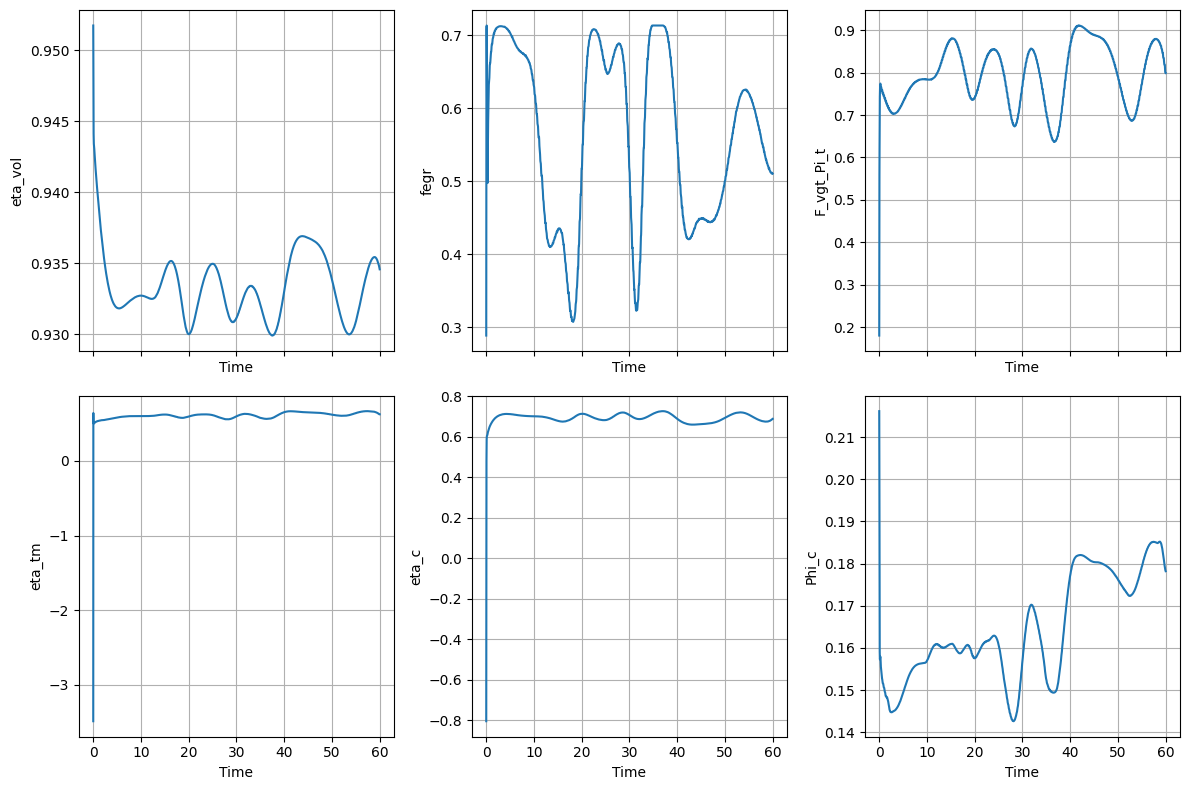

In [106]:
# Extracting time and data columns
time = df_analytical.iloc[:, 0]
data_columns = df_analytical.columns[1:]

# Setting up subplot grid dimensions
n = len(data_columns)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(n / cols)

# Creating figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axes = axes.flatten()  # Flatten to 1D for easy indexing

# We plot each column in its subplot
for i, col in enumerate(data_columns):
    axes[i].plot(time, df_analytical[col])
    axes[i].set_xlabel(df_analytical.columns[0])
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# Hiding any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Saving Datasets

In [124]:
df_empirical

,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,n_e,p_em,p_im,omegat,u_vgt,u_egr,W_ei,W_egr,T_em,W_t,W_c,T_c,domegat_dt
0,0.000000,0.952944,0.719035,0.119919,1.133810,0.200027,0.217494,1500,102371.759481,101339.735203,5236.000000,59.470000,18.308200,0.177690,0.003344,856.396676,0.020975,0.270270,299.419771,-2841.332587
1,0.021919,0.949986,0.816219,0.442985,1.133810,0.200027,0.210493,1500,126779.641219,110558.295191,5173.721536,42.271633,50.084203,0.193252,0.043630,854.370456,0.096070,0.258459,336.786809,-3997.708743
2,0.031917,0.948725,0.829078,0.475086,0.495480,0.332920,0.203127,1500,133496.117515,114609.765503,5128.478697,38.177619,60.006470,0.200068,0.049861,845.345229,0.109067,0.247234,330.931762,-4476.496600
3,0.034242,0.948457,0.831178,0.480599,0.457124,0.356811,0.201293,1500,134851.260190,115480.623215,5118.098000,37.440175,61.991419,0.201531,0.051011,843.031519,0.111606,0.244505,330.622310,-4410.597217
4,0.036566,0.948199,0.833060,0.485602,0.435733,0.378773,0.199408,1500,136142.945621,116323.406454,5107.971076,36.813493,63.865944,0.202947,0.052076,840.962862,0.113988,0.241737,330.448542,-4281.963211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.935973,0.544557,0.803468,0.598633,0.684221,0.152290,1500,170253.330355,159686.621004,6964.706525,54.880088,37.537091,0.275010,0.024811,717.912210,0.255270,0.251724,358.888226,64.148320
2196,59.867654,0.935944,0.545611,0.800108,0.596025,0.684807,0.152035,1500,170778.771345,159798.613166,6965.884225,54.198470,37.522807,0.275194,0.025675,718.179396,0.254940,0.251345,358.935341,75.288102
2197,59.896336,0.935888,0.546737,0.798258,0.591538,0.685773,0.151654,1500,171458.793513,160010.580351,6968.322029,53.282042,37.495468,0.275543,0.026647,718.321398,0.255338,0.250803,359.036642,95.463877
2198,59.936597,0.935815,0.547352,0.798157,0.588911,0.686756,0.151356,1500,172004.701219,160292.944131,6972.757291,52.784553,37.453723,0.276007,0.027200,718.099692,0.256158,0.250469,359.197846,126.580060


In [125]:
df_empirical_noisy_1.to_excel("Empirical Formulae Noisy 1%(2).xlsx", index = True)
df_empirical_noisy_2.to_excel("Empirical Formulae Noisy 2%(2).xlsx", index = True)
df_empirical_noisy_3.to_excel("Empirical Formulae Noisy 3%(2).xlsx", index = True)
df_empirical_noisy_4.to_excel("Empirical Formulae Noisy 4%(2).xlsx", index = True)
df_empirical_noisy_5.to_excel("Empirical Formulae Noisy 5%(2).xlsx", index = True)
df_empirical_noisy_10.to_excel("Empirical Formulae Noisy 10%(2).xlsx", index = True)
